In [242]:
import findspark
findspark.init()
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [262]:
import pandas as pd
from pyspark.sql.functions import udf
from datetime import datetime
from pyspark.sql.functions import year, month
from pyspark.sql.types import DateType, FloatType, IntegerType
df = spark.read.option("header",True) \
     .csv("data/dust.csv", encoding='euc-kr')

toDate = udf(lambda x: datetime.strptime(x, '%Y%m%d'), DateType())
df = df.withColumn('측정일자', toDate(df['측정일자']))
df = df.withColumn('권역코드', df['권역코드'].cast("integer"))
df = df.withColumn('측정소코드', df['측정소코드'].cast("integer"))
df = df.withColumn('미세먼지(㎍/㎥)', df['미세먼지(㎍/㎥)'].cast("integer"))
df = df.withColumn('오존(ppm)', df['오존(ppm)'].cast("float"))
df = df.withColumn('이산화질소농도(ppm)', df['이산화질소농도(ppm)'].cast("float"))
df = df.withColumn('일산화탄소농도(ppm)', df['일산화탄소농도(ppm)'].cast("float"))
df = df.withColumn('아황산가스농도(ppm)', df['아황산가스농도(ppm)'].cast("float"))
df = df.withColumn('초미세먼지(㎍/㎥)', df['초미세먼지(㎍/㎥)'].cast("integer"))

df.printSchema()

root
 |-- 측정일자: date (nullable = true)
 |-- 권역코드: integer (nullable = true)
 |-- 권역명: string (nullable = true)
 |-- 측정소코드: integer (nullable = true)
 |-- 측정소명: string (nullable = true)
 |-- 미세먼지(㎍/㎥): integer (nullable = true)
 |-- 오존(ppm): float (nullable = true)
 |-- 이산화질소농도(ppm): float (nullable = true)
 |-- 일산화탄소농도(ppm): float (nullable = true)
 |-- 아황산가스농도(ppm): float (nullable = true)
 |-- 초미세먼지(㎍/㎥): integer (nullable = true)



# 9-1 문제의 답

#### 1. 미세먼지의 양과 초미세먼지의 양은 상관관계에 있을까?
#### 2. 각 계절 그룹의 미세먼지의 양 간의 평균의 차이가 유의미할까?

# 9-2-1 시작

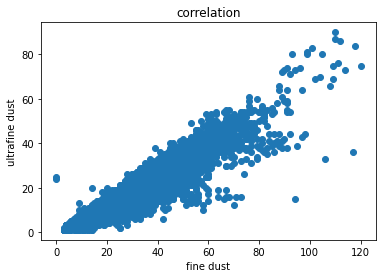

In [263]:
%matplotlib inline

from matplotlib import pyplot as plt

_dustRdd=df.rdd.map(lambda fields:fields['미세먼지(㎍/㎥)']).collect()
_microdustRdd=df.rdd.map(lambda fields:fields['초미세먼지(㎍/㎥)']).collect()

import numpy as np
import matplotlib.pyplot as plt

plt.title('correlation')
plt.plot(np.array(_dustRdd), np.array(_microdustRdd),'o')
plt.xlabel('fine dust')
plt.ylabel('ultrafine dust')
plt.show()

# 9-2-1의 답

In [264]:
import scipy.stats as stats

X = np.array(_dustRdd)
Y = np.array(_microdustRdd)

print(sum (stats.zscore(X) * stats.zscore(Y))/len(X))

0.9216213743659517


#### ※미세먼지의 양과 초미세먼지의 양 사이에는 강력한 상관관계가 있다.

# 9-2-2 시작

In [274]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

spring = datetime.strptime('20200301', '%Y%m%d')
summer = datetime.strptime('20200601', '%Y%m%d')
fall = datetime.strptime('20200901', '%Y%m%d')
winter = datetime.strptime('20201201', '%Y%m%d')

seasonUdf = udf(lambda x: "winter" if x<spring\
                else "spring" if spring<=x<summer\
                else "summer" if summer<=x<fall\
                else "fall" if fall<=x<winter\
                else "winter", StringType())

seasonDf = df.select(df['측정일자'],df['미세먼지(㎍/㎥)'])\
        .withColumn('season',seasonUdf(df['측정일자']))

seasonDf2 = df.withColumn('season',seasonUdf(df['측정일자']))

seasonDf.show()

+----------+---------------+------+
|  측정일자|미세먼지(㎍/㎥)|season|
+----------+---------------+------+
|2020-12-31|             29|winter|
|2020-12-31|             28|winter|
|2020-12-31|             34|winter|
|2020-12-31|             26|winter|
|2020-12-31|             20|winter|
|2020-12-31|             23|winter|
|2020-12-31|             24|winter|
|2020-12-31|             22|winter|
|2020-12-31|             24|winter|
|2020-12-31|             21|winter|
|2020-12-31|             23|winter|
|2020-12-31|             20|winter|
|2020-12-31|             30|winter|
|2020-12-31|             27|winter|
|2020-12-31|             27|winter|
|2020-12-31|             27|winter|
|2020-12-31|             23|winter|
|2020-12-31|             30|winter|
|2020-12-31|             22|winter|
|2020-12-31|             29|winter|
+----------+---------------+------+
only showing top 20 rows



In [272]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol="season", outputCol="label")
model=labelIndexer.fit(seasonDf2)
_df=model.transform(seasonDf2)

In [273]:
_df.show(4)

+----------+--------+------+----------+--------+---------------+---------+-------------------+-------------------+-------------------+-----------------+------+-----+
|  측정일자|권역코드|권역명|측정소코드|측정소명|미세먼지(㎍/㎥)|오존(ppm)|이산화질소농도(ppm)|일산화탄소농도(ppm)|아황산가스농도(ppm)|초미세먼지(㎍/㎥)|season|label|
+----------+--------+------+----------+--------+---------------+---------+-------------------+-------------------+-------------------+-----------------+------+-----+
|2020-12-31|     100|도심권|    111121|    중구|             29|     0.02|              0.016|                0.4|              0.003|               13|winter|  2.0|
|2020-12-31|     100|도심권|    111123|  종로구|             28|    0.022|              0.016|                0.4|              0.003|               12|winter|  2.0|
|2020-12-31|     100|도심권|    111131|  용산구|             34|    0.014|              0.019|                0.4|              0.003|               10|winter|  2.0|
|2020-12-31|     101|서북권|    111181|  은평구|             26|    0.023|         

In [291]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['이산화질소농도(ppm)', '미세먼지(㎍/㎥)', '오존(ppm)'], outputCol="features")
_trainDf = assembler.transform(_df)

In [292]:
_trainDf.show()

+----------+--------+------+----------+--------+---------------+---------+-------------------+-------------------+-------------------+-----------------+------+-----+--------------------+
|  측정일자|권역코드|권역명|측정소코드|측정소명|미세먼지(㎍/㎥)|오존(ppm)|이산화질소농도(ppm)|일산화탄소농도(ppm)|아황산가스농도(ppm)|초미세먼지(㎍/㎥)|season|label|            features|
+----------+--------+------+----------+--------+---------------+---------+-------------------+-------------------+-------------------+-----------------+------+-----+--------------------+
|2020-12-31|     100|도심권|    111121|    중구|             29|     0.02|              0.016|                0.4|              0.003|               13|winter|  2.0|[0.01600000075995...|
|2020-12-31|     100|도심권|    111123|  종로구|             28|    0.022|              0.016|                0.4|              0.003|               12|winter|  2.0|[0.01600000075995...|
|2020-12-31|     100|도심권|    111131|  용산구|             34|    0.014|              0.019|                0.4|              0.003|    

# 문제9-2-2의 답

In [295]:
from pyspark.ml.stat import ChiSquareTest
r = ChiSquareTest.test(_trainDf, "features", "label")
r.show()

+-------------+----------------+--------------------+
|      pValues|degreesOfFreedom|          statistics|
+-------------+----------------+--------------------+
|[0.0,0.0,0.0]| [213, 333, 258]|[1416.18557589984...|
+-------------+----------------+--------------------+



#### ※pValues의 값들이 0.0이므로, 이산화질소농도, 미세먼지의 양, 오존농도와 계절은 유의미한 상관관계를 갖는다.